In [1]:
# %matplotlib notebook

In [2]:
#dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
pd.set_option('display.max_columns', 50) #expand all dfs otherwise df with many columsn will be truncated

In [50]:
#import csv data files
# File to Load 
ad_data_to_load = "csv_data/Ad3.csv" #ad data file (only working with 1 of the 3)
cost_of_goods_to_load = "csv_data/cost_of_goods.csv" #cost of goods file
transactions_to_load="csv_data/transactions_main.csv" #transactions file

# Read the csvs
ad_data_raw =pd.read_csv(ad_data_to_load, index_col=False)
cost_of_goods_raw =pd.read_csv(cost_of_goods_to_load)
transactions_raw =pd.read_csv(transactions_to_load)

#create dfs
ad_df_raw = pd.DataFrame(ad_data_raw)
cog_df_raw = pd.DataFrame(cost_of_goods_raw)
trans_df_raw = pd.DataFrame(transactions_raw)

#merge trans df and cost of goods df together on 'sku'
combo_df =pd.merge(trans_df_raw, cog_df_raw, how='outer', on='sku', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)


In [116]:
combo_df.loc[:, 'date/time'].replace(regex=True,inplace=True,to_replace="PST", value="") #remove 'PST' from date/time; if PST or PDT remain an error will occur when converting 
combo_df.loc[:, 'date/time'].replace(regex=True,inplace=True,to_replace="PDT", value="") #remove 'PDT' from date/time; if PST or PDT remain an error will occur when converting
combo_df['date/time']=pd.to_datetime(combo_df['date/time']) #converts string date/time to datetime
combo_df.infer_objects(); #changes column types. Most are strings or objects and this converts them to floats. This may not be needed. Need to double check. But it works so keep it for now.


In [68]:
def trans_cols(x): #creates new cols and their calculations
    x['transaction revenue']= x['total']-x['est_cost_unit']#revenue generate from transaction (revenue - cost of goods)
    x['sale price']= x['product sales']/x['quantity']#generates price of item at sale
    #x['Day of Week']=""  #Mon, Tues, Weds etc...
    x['Cost of Goods']=x['quantity']*x['est_cost_unit'] #total cost of goods for transaction; used to tally reorder amounts
    x['Whole Date'] =pd.to_datetime(combo_df['date/time']).apply(lambda y: y.date()) #converts timestamp to date
    
trans_cols(combo_df) #apply the trans_cols function to create new columns
short_trans_df=combo_df.drop(['settlement id','order id','marketplace','fulfillment'],axis=1) #drop unimportant columns and create a smaller df
short_trans_df.sort_values('date/time').reset_index().head(5) #sort df and reset index to match



,index,date/time,type,sku,description,quantity,order city,order state,order postal,product sales,shipping credits,gift wrap credits,promotional rebates,sales tax collected,Marketplace Facilitator Tax,selling fees,fba fees,other transaction fees,other,total,asin,group,parent,child,est_cost_unit,pick_n_pack_fee,transaction revenue,sale price,Cost of Goods,Whole Date
0,24675,2015-04-10 17:25:27,FBA Inventory Fee,NaN,FBA Amazon-Partnered Carrier Shipment Fee,NaN,NaN,NaN,NaN,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,-4.33,-4.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-04-10
1,24676,2015-04-10 17:29:22,FBA Inventory Fee,NaN,FBA Amazon-Partnered Carrier Shipment Fee,NaN,NaN,NaN,NaN,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,-4.96,-4.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-04-10
2,355,2015-04-15 18:48:48,Order,48-JT2Z-XFJ6,Chocolate Disney Frozen Surprise Egg By Zaini-...,1.0,MANDAN,ND,58554-6280,21.99,0.0,3.49,0.0,0.0,0.0,-3.3,-6.16,0.0,0.00,16.02,NaN,NaN,Chocolate Eggs,Frozen Chocolate Eggs,2.31,NaN,13.71,21.99,2.31,2015-04-15
3,24677,2015-04-16 16:01:31,FBA Inventory Fee,NaN,FBA Amazon-Partnered Carrier Shipment Fee,NaN,NaN,NaN,NaN,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,-9.31,-9.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-04-16
4,24678,2015-04-16 16:15:31,FBA Inventory Fee,NaN,FBA Amazon-Partnered Carrier Shipment Fee,NaN,NaN,NaN,NaN,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,-7.62,-7.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-04-16


In [88]:
ad_data_clean=ad_data_raw
ad_data_clean['Date'] =pd.to_datetime(ad_data_clean['Date']).apply(lambda y: y.date())#converts string date to date

def ad_cols(x): #creates new cols and their calculations
    x['Whole Date'] =pd.to_datetime(ad_data_clean['Date']).apply(lambda y: y.date()) #converts timestamp to date
    
ad_cols(ad_data_clean) #apply the trans_cols function to create new columns
short_ad_df=ad_data_clean.drop(['Currency'],axis=1) #drop unimportant columns and create a smaller df
short_ad_df['Spend']=short_ad_df['Spend'].replace('[\$,]', '', regex=True).astype(float) #removes $ and converts to float
short_ad_df.head(5)

,Date,Campaign Name,Ad Group Name,Advertised SKU,Advertised ASIN,Impressions,Clicks,Click-Thru Rate (CTR),Cost Per Click (CPC),Spend,7 Day Total Sales,Total Advertising Cost of Sales (ACoS),Total Return on Advertising Spend (RoAS),7 Day Total Orders (#),7 Day Total Units (#),7 Day Conversion Rate,7 Day Advertised SKU Units (#),7 Day Other SKU Units (#),7 Day Advertised SKU Sales,7 Day Other SKU Sales,Whole Date
0,2018-05-08,Copper Ant Guard-Qty-3-Auto,Ad Group 1,Ant Guard Qty 3,B0763T3CTK,0,0,NaN,NaN,0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00,2018-05-08
1,2018-05-07,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,19,0,0.00%,NaN,0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00,2018-05-07
2,2018-05-08,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,16,0,0.00%,NaN,0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00,2018-05-08
3,2018-05-09,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,12,0,0.00%,NaN,0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00,2018-05-09
4,2018-05-10,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,11,1,9.09%,$0.08,0.08,$0.00,NaN,0.0,0,0,0.00%,0,0,$0.00,$0.00,2018-05-10


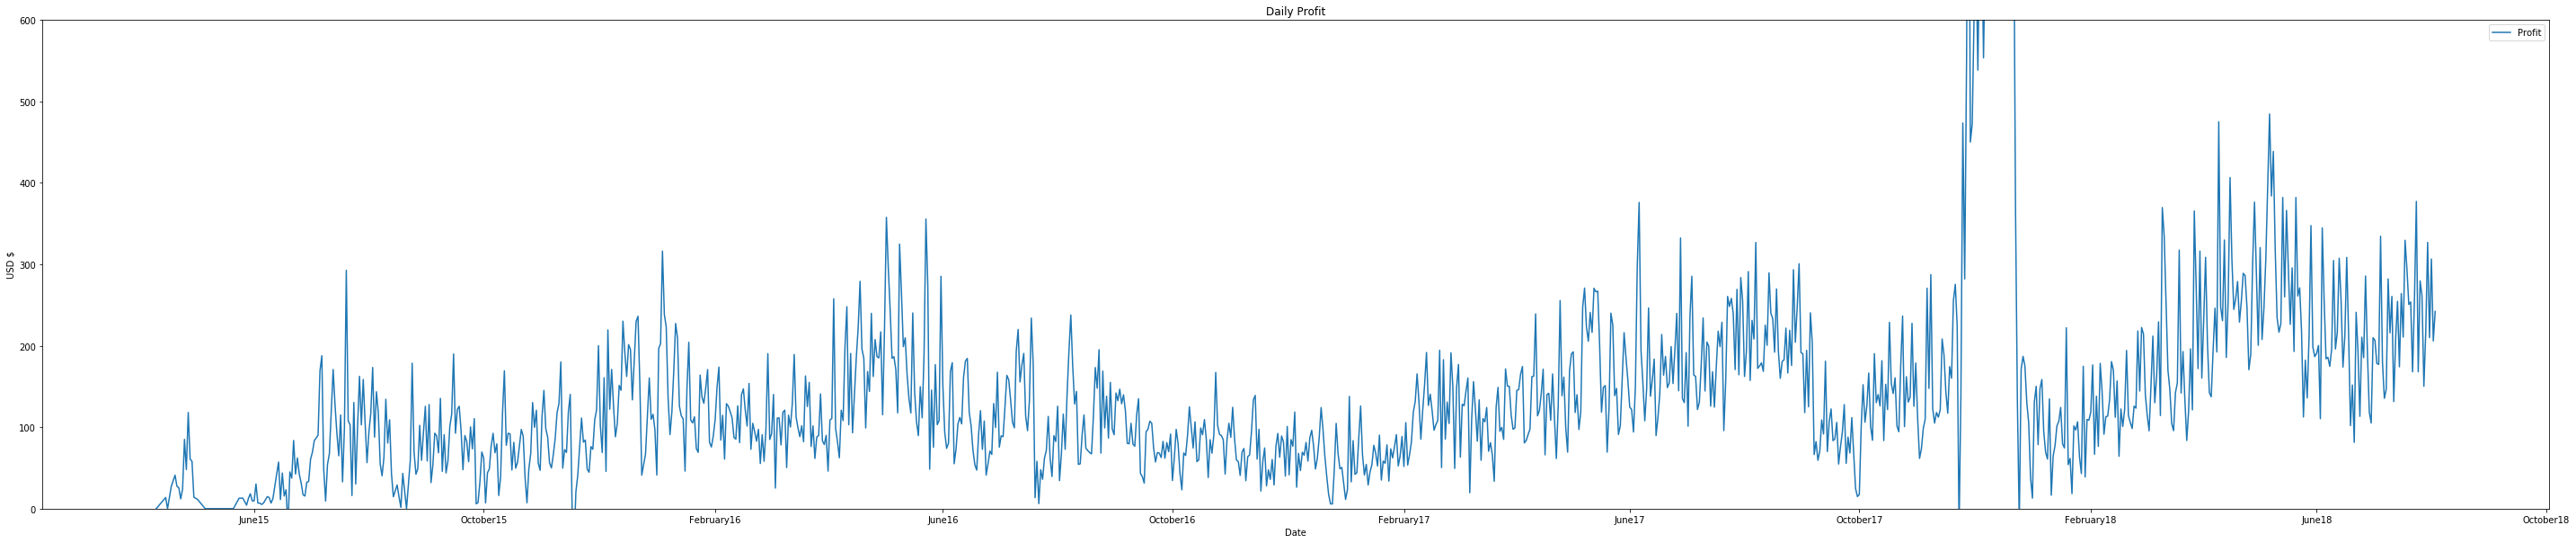

In [55]:
#profit graph
def profit_graph():
    
    def trans_rev(x): #create a df with sum transactions grouped by date
        cols={'Transaction Revenue':x['transaction revenue'].sum()}
        return pd.Series(cols)
    rev_df=combo_df.groupby('Whole Date').apply(trans_rev)
    rev_df.reset_index;()#reset index so "Whole Date" can be used
     
    def ad_spend_daily(x): #create a df with sum transactions grouped by date
        cols={'Ad Spend':x['Spend'].sum()}
        return pd.Series(cols)
    daily_ad_spend_df=short_ad_df.groupby(['Date']).apply(ad_spend_daily)
    
    prof_df =pd.merge(daily_ad_spend_df, rev_df, how='outer', left_on="Date", right_on="Whole Date",
             left_index=False, right_index=True, sort=True,
             suffixes=('_x', '_y'), copy=True, indicator=False,
             validate=None)
    #prof_df.head()
    prof_df['Profit']=prof_df['Transaction Revenue']-prof_df['Ad Spend']
    prof_df['Profit'].fillna(prof_df['Transaction Revenue'],inplace=True)
    x=prof_df.index
    y=prof_df['Profit'] 
    
    fig = plt.figure(figsize=(50,10))#creates figure
    ax= fig.add_subplot(1,1,1)
    ax.set_ylim([0,600])
    ax.plot(x, y)
    ax.set_title('Daily Profit')
    ax.set_xlabel('Date')
    ax.set_ylabel('USD $')
    ax.legend(loc='best')

    
    myFmt = mdates.DateFormatter('%B%y')
    ax.xaxis.set_major_formatter(myFmt)
    
profit_graph()



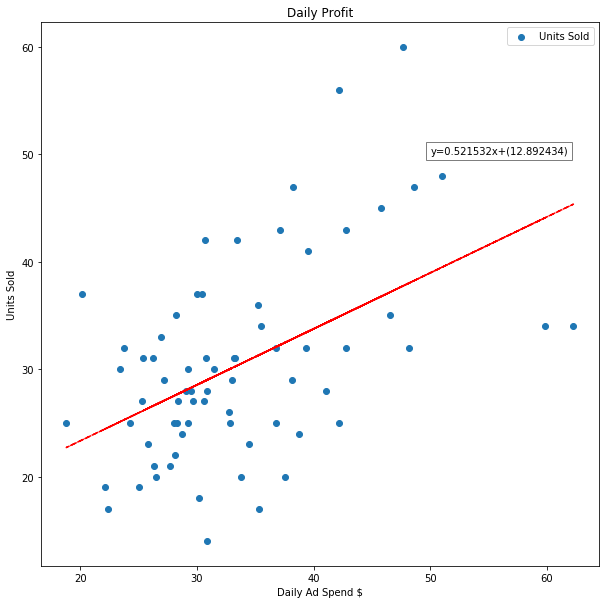

In [100]:
#ad spend vs units sold
def ad_spend_v_units():
    def ad_spend(x): #create a df with sum transactions grouped by date
        cols={'Daily Ad Spend':x['Spend'].sum()}
        return pd.Series(cols)
    daily_ad_spend_df=short_ad_df.groupby('Date').apply(ad_spend)
    daily_ad_spend_df.reset_index();#reset index so "Whole Date" can be used

    def units(x): #create a df with sum transactions grouped by date
        cols={'Units Sold':x['quantity'].sum()}
        return pd.Series(cols)
    units_df=short_trans_df.groupby('Whole Date').apply(units)
    units_df.reset_index()#reset index so "Whole Date" can be used

    ad_v_units_df =pd.merge(daily_ad_spend_df, units_df, how='inner', left_on="Date", right_on="Whole Date",
                 left_index=False, right_index=True, sort=True,
                 suffixes=('_x', '_y'), copy=True, indicator=False,
                 validate=None)

    x=ad_v_units_df['Daily Ad Spend']
    y=ad_v_units_df['Units Sold']

    fig = plt.figure(figsize=(10,10))#creates figure
    ax= fig.add_subplot(1,1,1)
    ax.scatter(x, y)
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x,p(x),"r--")
    # the line equation:
    equation="y=%.6fx+(%.6f)"%(z[0],z[1])
    
    ax.set_title('Daily Profit')
    ax.set_xlabel('Daily Ad Spend $')
    ax.set_ylabel('Units Sold')
    ax.legend(loc='best')
    ax.text(50,50,equation,bbox=dict(facecolor='white',alpha=0.5))
    
ad_spend_v_units() #may include returns, double check if time

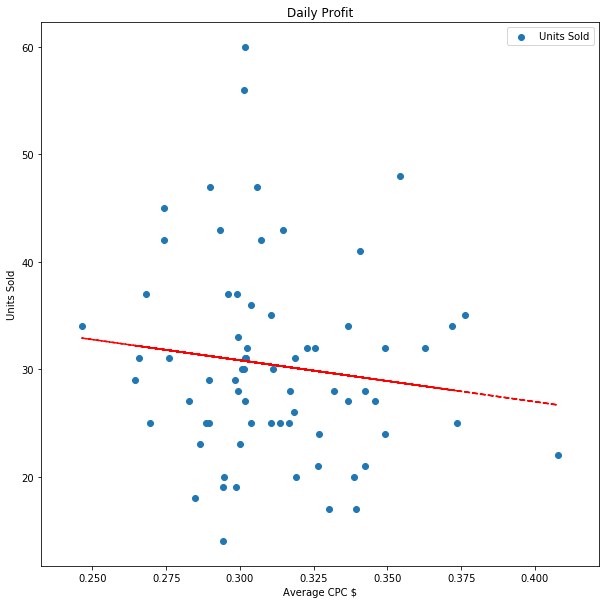

In [115]:
def cpc_graph():
    def cpc(x): #create a df with sum transactions grouped by date
        cols={'Average CPC':x['Spend'].sum()/x['Clicks'].sum()}
        return pd.Series(cols)
    daily_cpc_average_df=short_ad_df.groupby('Date').apply(cpc)
    daily_cpc_average_df.reset_index()

    def units(x): #create a df with sum transactions grouped by date
        cols={'Units Sold':x['quantity'].sum()}
        return pd.Series(cols)
    units_df=short_trans_df.groupby('Whole Date').apply(units)
    units_df.reset_index()#reset index so "Whole Date" can be used

    cpc_v_units_df =pd.merge(daily_cpc_average_df, units_df, how='inner', left_on="Date", right_on="Whole Date",
                     left_index=False, right_index=True, sort=True,
                     suffixes=('_x', '_y'), copy=True, indicator=False,
                     validate=None)

    x=cpc_v_units_df['Average CPC']
    y=cpc_v_units_df['Units Sold']

    fig = plt.figure(figsize=(10,10))#creates figure
    ax= fig.add_subplot(1,1,1)
    ax.scatter(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x,p(x),"r--")
    # the line equation:
    equation="y=%.6fx+(%.6f)"%(z[0],z[1])

    ax.set_title('Daily Profit')
    ax.set_xlabel('Average CPC $')
    ax.set_ylabel('Units Sold')
    ax.legend(loc='best')
    #ax.text(20,20,equation,bbox=dict(facecolor='white',alpha=0.5))

cpc_graph()

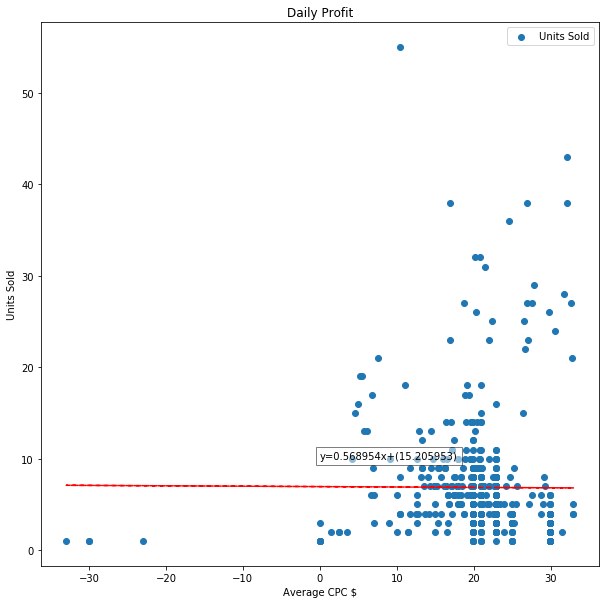

In [144]:

def zen_price():
    zen_df=short_trans_df[short_trans_df['sku']=='UK-AVWR-4MNQ']

    def avg_price(x): #create a df with sum transactions grouped by date
        cols={'Average Price':x['sale price'].sum()/x['quantity'].sum()}
        return pd.Series(cols)
    avg_price_df=zen_df.groupby('Whole Date').apply(avg_price)
    avg_price_df.dropna(inplace=True)#reset index so "Whole Date" can be used
    avg_price_df.reset_index()

    def units(x): #create a df with sum transactions grouped by date
        cols={'Units Sold':x['quantity'].sum()}
        return pd.Series(cols)
    units_df=zen_df.groupby('Whole Date').apply(units)
    units_df.reset_index()#reset index so "Whole Date" can be used

    price_v_units_df =pd.merge(avg_price_df, units_df, how='inner', left_on="Whole Date", right_on="Whole Date",
                         left_index=False, right_index=True, sort=True,
                         suffixes=('_x', '_y'), copy=True, indicator=False,
                         validate=None)

    x=price_v_units_df['Average Price']
    y=price_v_units_df['Units Sold']

    fig = plt.figure(figsize=(10,10))#creates figure
    ax= fig.add_subplot(1,1,1)
    ax.scatter(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x,p(x),"r--")
    # the line equation:
    #equation="y=%.6fx+(%.6f)"%(z[0],z[1])

    ax.set_title('Daily Profit')
    ax.set_xlabel('Average CPC $')
    ax.set_ylabel('Units Sold')
    ax.legend(loc='best')
    ax.text(0,10,equation,bbox=dict(facecolor='white',alpha=0.5))

zen_price()


In [139]:
zen_df=short_trans_df[short_trans_df['sku']=='UK-AVWR-4MNQ']